In [1]:
import os
from json import load, dumps, dump
from tqdm import tqdm
import numpy as np

from hbo_bench.oracle import Oracle, OracleRequest, TIMEOUT
from hbo_bench.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET, DEFAULT_DOP
from hbo_bench.utils import get_logical_tree, get_full_plan

import matplotlib.pyplot as plt
import seaborn as sns

ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
BTCNN_PATH = os.path.join(ROOT_PATH, "btcnn/src/btcnn")
HBO_BENCH_PATH = os.path.join(ROOT_PATH, "hbo_bench/src/hbo_bench")
EXPERIMENT_PATH = os.getcwd()
ARTIFACTS_PATH = os.path.join(EXPERIMENT_PATH, "artifacts")

In [2]:
cached_oracles = {
    "JOB": Oracle(f"{HBO_BENCH_PATH}/data/processed/JOB"),
    "TPCH": Oracle(f"{HBO_BENCH_PATH}/data/processed/tpch_10gb"),
    "SQ": Oracle(f"{HBO_BENCH_PATH}/data/processed/sample_queries"),
}

In [3]:
def get_e2e_time(oracle, q_n, hs, dop):
    request = OracleRequest(query_name=q_n, hintset=hs, dop=dop)
    return (oracle.get_planning_time(request) + oracle.get_execution_time(request)) / 1000

In [4]:
def plot_bars(
    times, 
    labels, 
    names, 
    xlabel='Query',
    ylabel='Execution Time (s)',
    title="Execution Time Comparison",
    figsize=(12, 6),
    bar_width=0.25,
    label_fontsize=15, 
    title_fontsize=18, 
    tick_label_fontsize=15, 
    legend_fontsize=15, 
    bar_label_fontsize=13,
    save_name=None
):
    sns.set_style("ticks")
    sns.set_palette("deep")
    
    x = np.arange(len(names))

    fig, ax = plt.subplots(figsize=figsize)

    for i in range(len(labels)):
        ax.bar(x + i * bar_width, times[:, i], bar_width, label=labels[i])

    for i in range(len(names)):
        for j in range(len(labels)):
            ax.text(x[i] + j * bar_width, times[i, j], f'{times[i, j]:.1f}s', ha='center', va='bottom', fontsize=bar_label_fontsize, fontweight='bold')

    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(names, fontsize=tick_label_fontsize)
    ax.legend(fontsize=legend_fontsize, loc='best')
    ax.grid(alpha=0.3, color='gray')
    
    if save_name:
        plt.savefig(f"{ARTIFACTS_PATH}/{save_name}", format='svg', dpi=300)
    plt.show()

# Example 1

For advising good hints we must take into accout planner's implementation.

In [5]:
job_oracle = cached_oracles["JOB"]
OFF_NL_HINT = 64
OFF_INL_HINT = 64 | 8 | 2

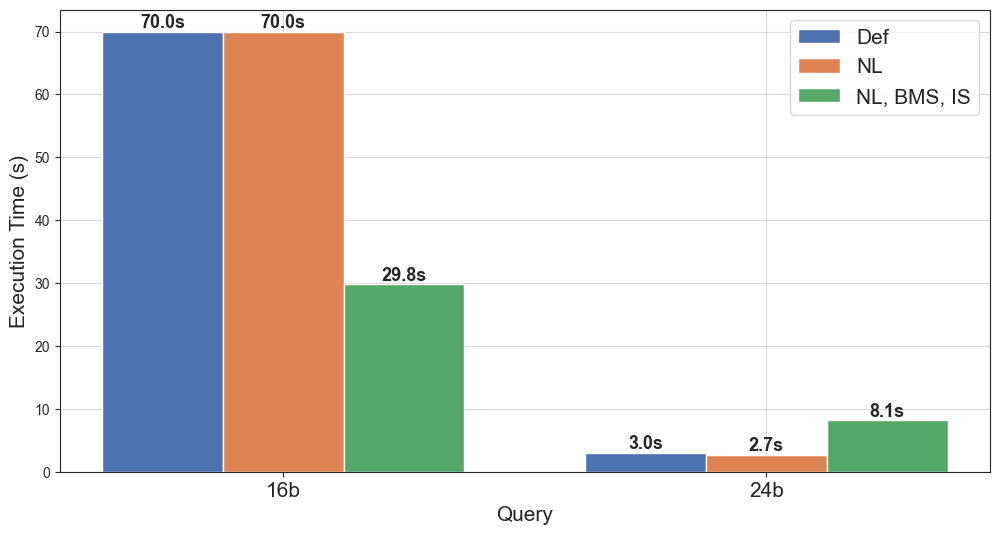

In [6]:
query_names = ["16b", "24b"]
times = np.array([
    [get_e2e_time(job_oracle, q_n, hs, DEFAULT_DOP) for hs in [DEFAULT_HINTSET, OFF_NL_HINT, OFF_INL_HINT]]
    for q_n in query_names
])

labels = ['Def', 'NL', 'NL, BMS, IS']
plot_bars(times, labels, query_names, title="", save_name="example_16b_24b.svg")

**Conclusion.** \
Comparing the behaviour of these same queries with the same hints on `PostgreSQL` (as in `Bao`'s article), we can see that it is *fundamentally different*. This is because `openGauss` has a slightly different scheduler, and in case of `16b` it ignores switching off `NestedLoop` (actually `Nested Index Loop Join` is switched off only by a combination of several hints at once). Moreover, we can immediately realise - that there are **no universally good hints** - they can both significantly speed up queries (`16b`) and repeatedly slow down others (`24b`).

# Example 2

There're no universally good hints.

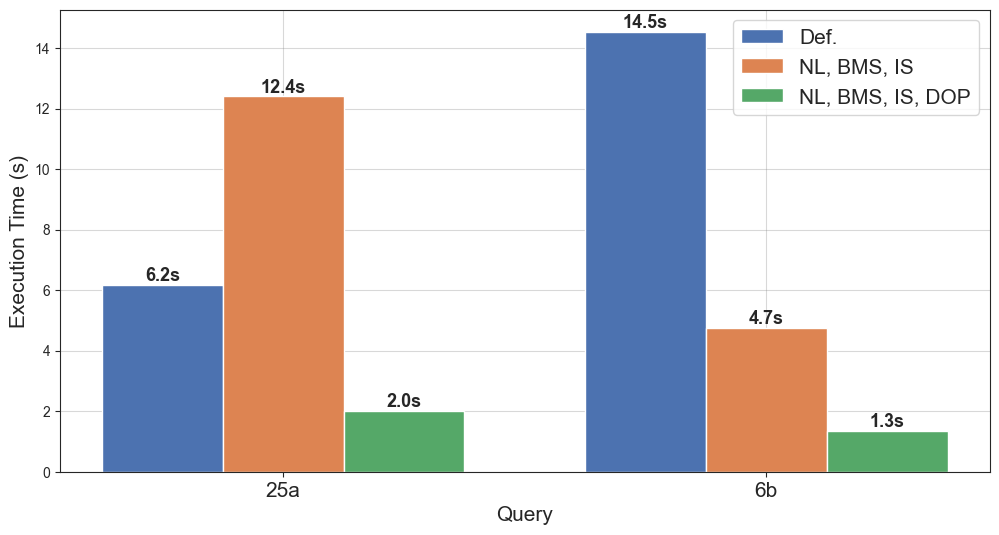

In [7]:
query_names = ["25a", "6b"]
times = np.array([
    [get_e2e_time(job_oracle, q_n, hs, dop) for (hs, dop) in [(DEFAULT_HINTSET, DEFAULT_DOP), (OFF_INL_HINT, DEFAULT_DOP), (OFF_INL_HINT, 16)]]
    for q_n in query_names
])

labels = ['Def.', 'NL, BMS, IS', 'NL, BMS, IS, DOP']
plot_bars(times, labels, query_names, title="", save_name="example_25a6b.svg")

### What happened?

To understand what happens with query `25a`, we can analyse the plans:

```python
dop = 16
with open(f"{HBO_BENCH_PATH}/data/raw/dop{dop}/JOB.json", "r") as f:
    job_data = load(f)
query_data = job_data["25a.sql"]
explain_plan = query_data["hs_to_explain_plan"][str(OFF_INL_HINT)]
query_data["explain_plan_to_explain_analyze_plan"][dumps(explain_plan)]
```

**Default Plan:**

```python
'Node Type': 'Nested Loop',
'Plan Rows': 5,
'Actual Total Time': 3157.857,
'Actual Rows': 12438,
'Actual Loops': 1,
'Plans': [
    {
        'Node Type': 'Seq Scan',
        'Plan Rows': 1,
        'Actual Startup Time': 0.057,
        'Actual Total Time': 0.087,
        'Actual Rows': 1,
        'Actual Loops': 1,
    },
    {
        'Node Type': 'Nested Loop',
        'Plan Rows': 166,
        'Actual Total Time': 3150.975,
        'Actual Rows': 13309,
        'Actual Loops': 1,
        'Plans': [
            {
                'Node Type': 'Nested Loop',
                'Plan Rows': 165,
                'Actual Total Time': 211.298,
                'Actual Rows': 62096, # 165 << 62096 - huge cardinality underestimation
                'Actual Loops': 1,
                'Plans': [
                    {
                        'Node Type': 'Seq Scan',
                        'Plan Rows': 5,
                        'Actual Total Time': 60.023,
                        'Actual Rows': 5,
                        'Actual Loops': 1,
                    },
                    {
                        'Node Type': 'Bitmap Heap Scan',
                        'Plan Rows': 33,
                        'Actual Total Time': 136.146,
                        'Actual Rows': 62096,
                        'Actual Loops': 5,
                        'Plans': [
                            {
                                'Node Type': 'Bitmap Index Scan',
                                'Plan Rows': 33,
                                'Actual Total Time': 12.456,
                                'Actual Rows': 62096, # the source of underestimation
                                'Actual Loops': 5,
                            }
                        ]
                    }
                ]
            },
            {
                'Node Type': 'Index Scan',
                'Plan Rows': 1,
                'Actual Total Time': 2901.719,  # that is ~50% of execution time
                'Actual Rows': 13309,
                'Actual Loops': 62096,  # planner expected only 165 look-ups here
            }
        ]
    }
]
```

**Plan with disabled Nested Loop:**

```python
...
'Node Type': 'Streaming(type: BROADCAST dop: 64/1)',
'Plan Rows': 16256,  # 16256 << 9774080 - huge cardinality underestimation
'Actual Min Total Time': 11134.643,
'Actual Max Total Time': 11327.461,
'Actual Total Rows': 9774080,
'Plans': [
  {
    'Node Type': 'Hash Join',
    'Plan Rows': 254,
    'Actual Min Total Time': 4374.092,
    'Actual Max Total Time': 4374.092,
    'Actual Total Rows': 152720,
  },
  ...
]
```

**Conclusion.** \
The cause of errors is a huge underestimation of cardinality, which led to calling `60K` index lookups. In the situation when the nested loop is disabled, the planner chooses `HashJoin`, but at some point it parallelises the join of a huge relation (`10M`+) on 64 threads, because of which it gets a huge overhead. With lower degree of parallelism this does not happen (different plan is built).

# DOP

Control of the degree of parallelism (`dop`) parameter is also useful.

## DOP helps accelerate the workload

In [8]:
def get_best_time(oracle, query_name, hintsets, dops):
    return min(get_e2e_time(oracle, query_name, hs, dop) for hs in hintsets for dop in dops)

In [9]:
def get_worst_time(oracle, query_name, hintsets, dops):
    return max(get_e2e_time(oracle, query_name, hs, dop) for hs in hintsets for dop in dops)

In [10]:
times = []
labels = ["Default", "DOP", "OPs", "OPs & DOP"]

for bench_name, oracle in cached_oracles.items():
    ops_best_time = sum(get_best_time(oracle, q_n, HINTSETS, [DEFAULT_DOP]) for q_n in oracle.get_query_names())
    dop_best_time = sum(get_best_time(oracle, q_n, [DEFAULT_HINTSET], DOPS) for q_n in oracle.get_query_names())
    ops_and_dop_best_time = sum(get_best_time(oracle, q_n, HINTSETS, DOPS) for q_n in oracle.get_query_names())
    def_time = sum(get_best_time(oracle, q_n, [DEFAULT_HINTSET], [DEFAULT_DOP]) for q_n in oracle.get_query_names())
    times.append([def_time, dop_best_time, ops_best_time, ops_and_dop_best_time])

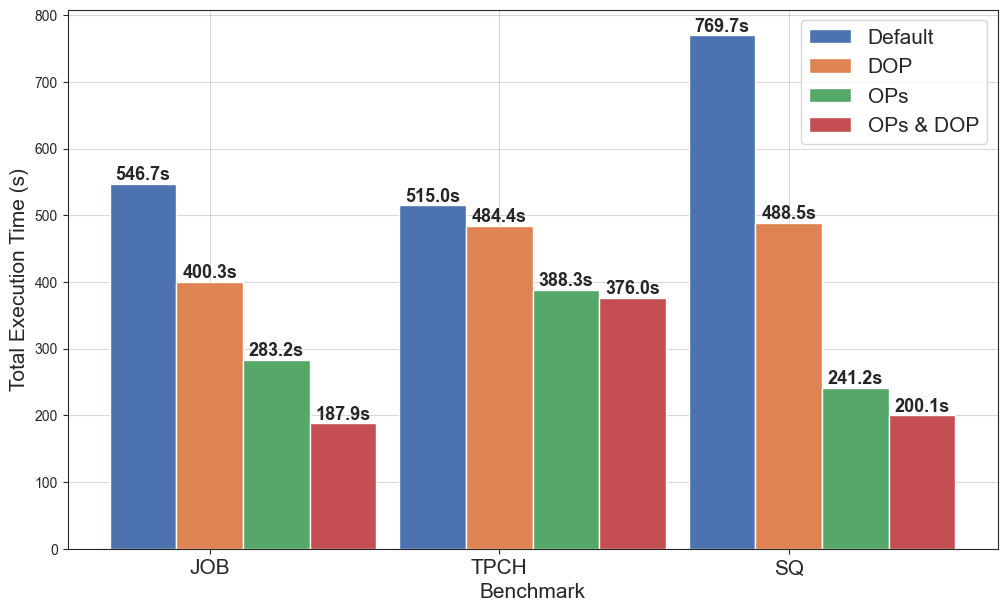

In [11]:
plot_bars(
    np.array(times), 
    labels, 
    cached_oracles.keys(),
    figsize=(12, 7),
    bar_width=0.23,
    xlabel="Benchmark",
    ylabel="Total Execution Time (s)",
    save_name="example_search_space.svg",
    title="",
)

As we can see, the boost from applying hints depends on the benchmark. For example, on `TPCH` the gain is much less than on `JOB`, and even more so on `SQ`. The reason is that we only correct the planner's errors - if it is not wrong, we have nothing to optimise. At the same time, the degree of parallelism itself is a rather effective parameter for optimisation and it also allows us to accelerate workload after applying hints on operators. 

## DOP expands the search space and raises the problem of effective exploration.

In [12]:
def get_exploration_time(oracle, query_name, hintsets, dops):
    return sum(
        min(get_e2e_time(oracle, query_name, hs, dop), get_e2e_time(oracle, query_name, DEFAULT_HINTSET, DEFAULT_DOP))    
        for hs in hintsets for dop in dops
    )
    
def get_planning_time(oracle, query_name, hintsets, dops):
    return sum(
        oracle.get_planning_time(OracleRequest(query_name=query_name, hintset=hs, dop=dop)) / 1000
        for hs in hintsets for dop in dops
    )

def get_explain_plan(oracle, query_name, hintset, dop):
    return oracle.get_explain_plan(OracleRequest(query_name=query_name, hintset=hintset, dop=dop))

def get_n_logical_trees(oracle, query_name, hintsets, dops):
    return len(set(get_logical_tree(get_explain_plan(oracle, query_name, hs, dop)) for hs in hintsets for dop in dops))

def get_n_full_plans(oracle, query_name, hintsets, dops):
    return len(set(get_full_plan(get_explain_plan(oracle, query_name, hs, dop)) for hs in hintsets for dop in dops))

In [13]:
def calculate_stats(oracle, hintsets, dops):
    stats = {
        "exploration_time": 0,
        "planning_time": 0,
        "n_logical_trees": 0,
        "n_full_plans": 0,
        "size": 0
    }

    for q_n in oracle.get_query_names():
        stats["exploration_time"] += get_exploration_time(oracle, q_n, hintsets, dops)
        stats["planning_time"] += get_planning_time(oracle, q_n, hintsets, dops)
        stats["n_logical_trees"] += get_n_logical_trees(oracle, q_n, hintsets, dops)
        stats["n_full_plans"] += get_n_full_plans(oracle, q_n, hintsets, dops)
        stats["size"] += len(hintsets) * len(dops)
    
    return stats

In [14]:
import pandas as pd

def get_stats_table(cached_oracles, labels, params):
    data = []
    for label, (hintsets, dops) in zip(labels, params):
        for bench_name, oracle in cached_oracles.items():
            stats = calculate_stats(oracle, hintsets, dops)
            data.append([
                bench_name, label, 
                int(stats["exploration_time"]),
                int(stats["planning_time"]), 
                int(stats["n_logical_trees"]), 
                int(stats["n_full_plans"]), 
                int(stats["size"])
            ])

    columns = ["Benchmark", "Search Space", "E2E Time (sec)", "Planning Time (sec)", 
               "# Unique Trees", "# Unique Plans", "# Plans"]
    df = pd.DataFrame(data, columns=columns)
    
    benchmark_order = ["TPCH", "JOB", "SQ"]
    df['Benchmark'] = pd.Categorical(df['Benchmark'], categories=benchmark_order, ordered=True)
    df = df.sort_values('Benchmark').reset_index(drop=True)
    
    return df

In [15]:
import pandas as pd

labels = ["DOP", "OPs", "OPs & DOP"]
params = [([DEFAULT_HINTSET], DOPS), (HINTSETS, [DEFAULT_DOP]), (HINTSETS, DOPS)]

df = get_stats_table(cached_oracles, labels, params)
df = df.pivot_table(index="Benchmark", columns="Search Space", values=["E2E Time (sec)", "Planning Time (sec)", "# Unique Trees", "# Unique Plans", "# Plans"], observed=False)

df["E2E Time (sec)"] = df["E2E Time (sec)"].astype(int)
df["Planning Time (sec)"] = df["Planning Time (sec)"].astype(int)
df["# Unique Trees"] = df["# Unique Trees"].astype(int)
df["# Unique Plans"] = df["# Unique Plans"].astype(int)
df["# Plans"] = df["# Plans"].astype(int)

pivot_df = df.reorder_levels([1, 0], axis=1).sort_index(axis=1)
pivot_df = pivot_df.reset_index()

pivot_df.to_csv(f"{ARTIFACTS_PATH}/search_space_statistics.csv", index=False)

In [16]:
pivot_df

Search Space Benchmark     DOP                                               \
                       # Plans # Unique Plans # Unique Trees E2E Time (sec)   
0                 TPCH      66             35             35           1492   
1                  JOB     339            215            206           1445   
2                   SQ     120             97             95           2002   

Search Space                         OPs                                \
             Planning Time (sec) # Plans # Unique Plans # Unique Trees   
0                              0    2816            415            415   
1                            263   14464           4167           3837   
2                            157    5120           2162           2064   

Search Space                                    OPs & DOP                 \
             E2E Time (sec) Planning Time (sec)   # Plans # Unique Plans   
0                     61156                   9      8448            600   
1                     58468                7510     43392           7692   
2                     75048                4804     15360           4524   

Search Space                                                    
             # Unique Trees E2E Time (sec) Planning Time (sec)  
0                       599         182477                  24  
1                      7050         172378               21337  
2                      4271         223740               13109

# Degradations

Hint can slow down the query, so it is necessary to build a **reliable** model. 

In [17]:
GREEN = "#55a868"
ORANGE = "#dd8452"
BLUE = "#4c72b0"
RED = "#c44e52"
TIMEOUT_REL = -1
TIMEOUT_VAL = -1

In [18]:
def _extract_query_number(query_name):
    import re
    return int(re.search(r"-?\d+\.?\d*", query_name).group())

In [19]:
def plot_per_query_bars(
    names, 
    boosts, 
    degradations, 
    title="", 
    path_to_save=None,
    bar_width=0.7,
    label_fontsize=15, 
    title_fontsize=18, 
    tick_label_fontsize=10, 
    legend_fontsize=15,
    figsize=(12, 6),
    grid_alpha=0.3,
    grid_color='gray'
):
    sns.set_style("ticks")
    sns.set_palette("deep")

    index = np.arange(len(names))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    timeout_index = [i for i, degr in enumerate(degradations) if degr == TIMEOUT_REL]
    degradation_index = [i for i, degr in enumerate(degradations) if degr != TIMEOUT_REL]
    
    degradation_vals = [degradations[i] for i in degradation_index]
    
    boost_bars = ax.bar(index, boosts, bar_width, label='Max Boost', color=GREEN)
    
    if timeout_index:
        timeout_vals = [TIMEOUT_VAL for _ in timeout_index]
        timeout_bars = ax.bar(timeout_index, timeout_vals, bar_width, label='T/O', color=RED)
    
    if degradation_index:
        degrade_bars = ax.bar(degradation_index, degradation_vals, bar_width, label='Max Degradation', color=ORANGE)
    
    left_edge = index[0] - bar_width / 2
    right_edge = index[-1] + bar_width / 2
    ax.plot([left_edge, right_edge], [0.0, 0.0], color='white', linewidth=0.1, linestyle='-')

    ax.set_yscale("symlog")
    ax.set_xlabel('Query', fontsize=label_fontsize)
    ax.set_ylabel('Relative Boost (log scale)', fontsize=label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xticks(index)
    ax.set_xticklabels(names, rotation=90, fontsize=tick_label_fontsize, fontweight='bold')
    ax.legend(fontsize=legend_fontsize, loc="upper right")
    ax.grid(alpha=0.3, color='gray')
    
    if path_to_save:
        plt.savefig(path_to_save, dpi=300, format='svg')
    plt.show()

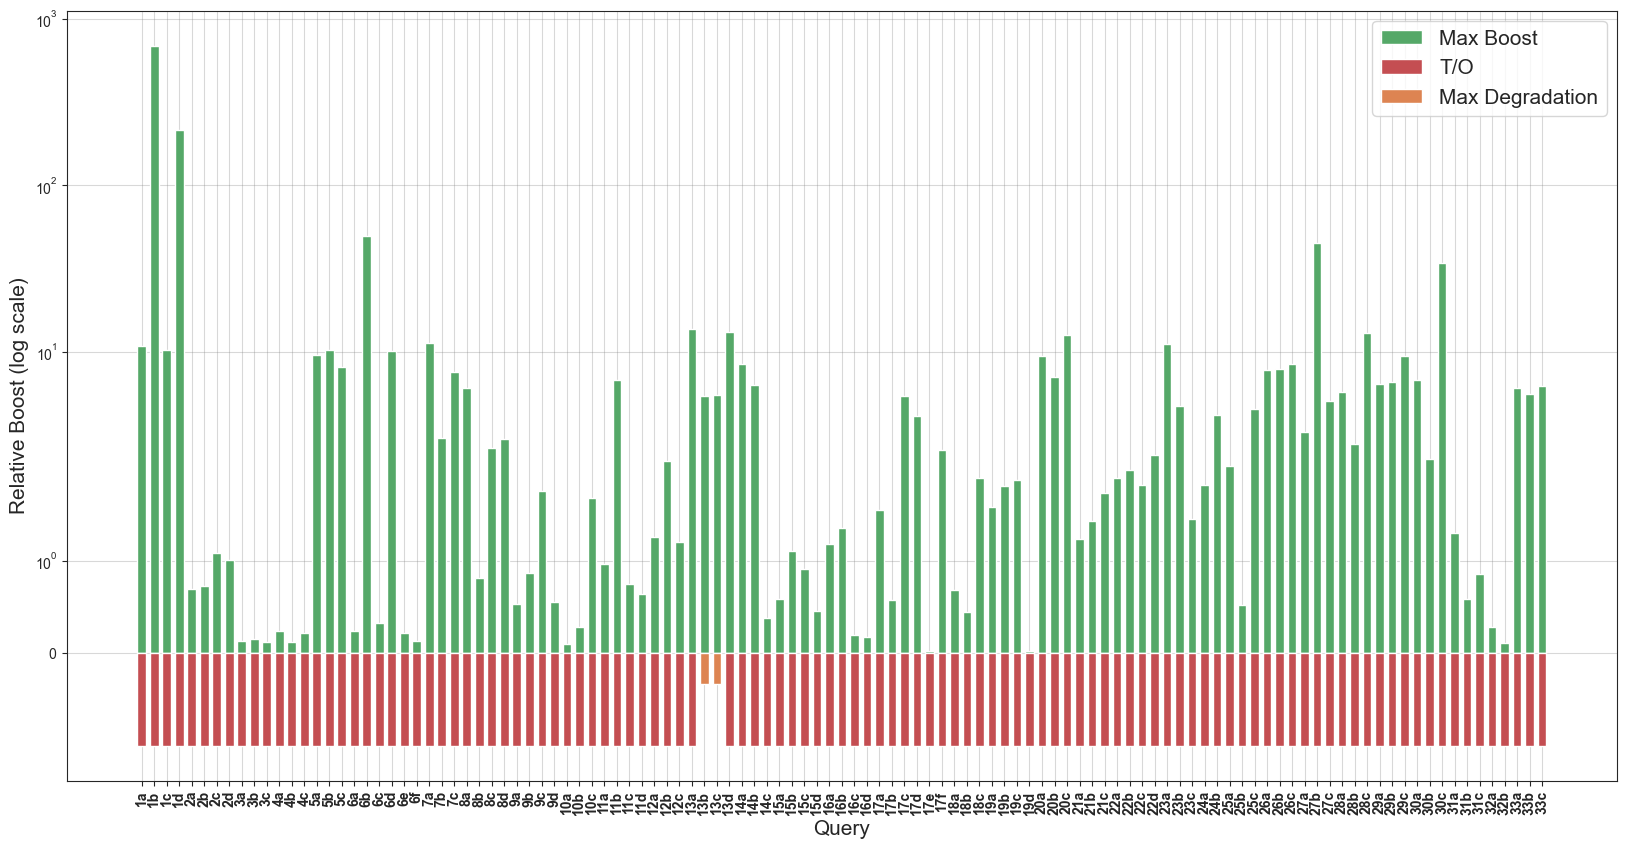

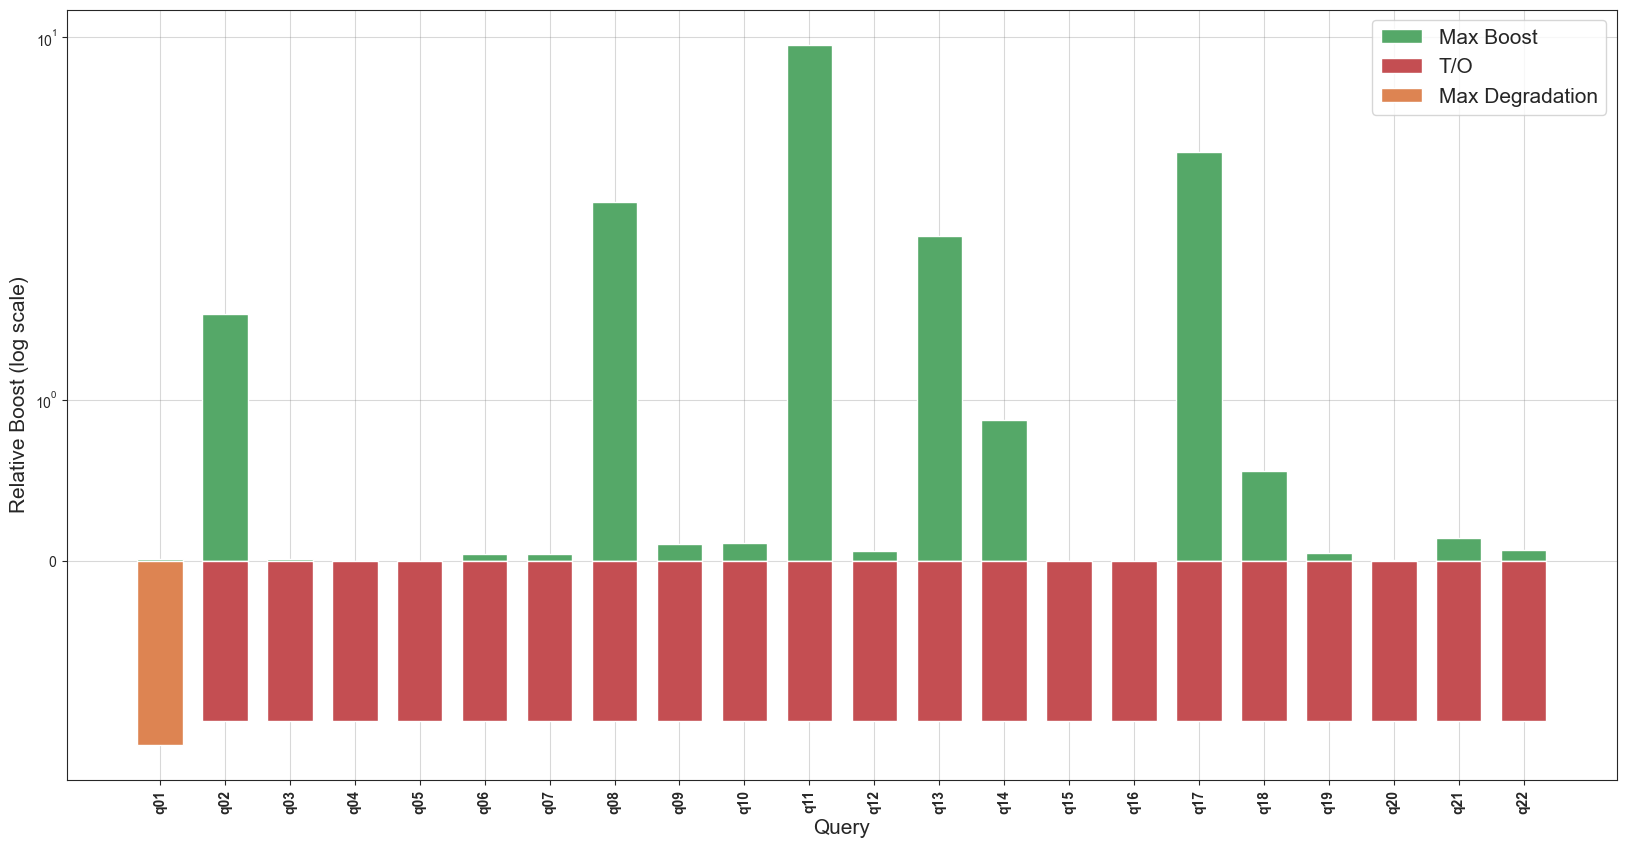

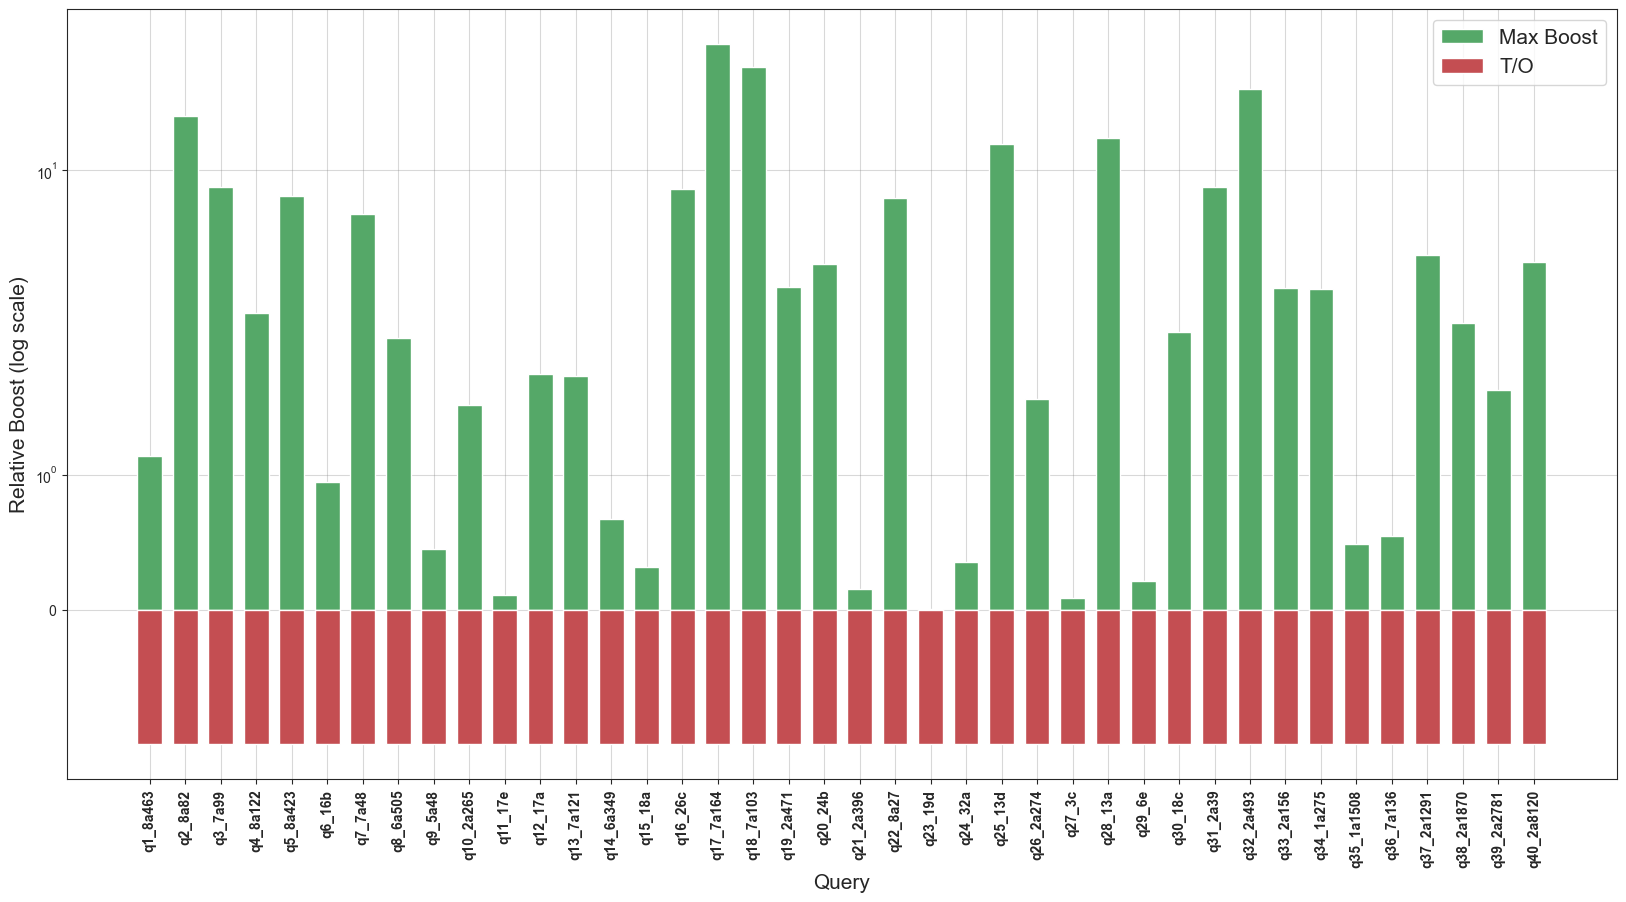

In [20]:
for bench_name, oracle in cached_oracles.items():
    names, boosts, degradations = [], [], []
    for q_n in sorted(oracle.get_query_names(), key=lambda el: (_extract_query_number(el), el)):
        
        best_time = get_best_time(oracle, q_n, HINTSETS, DOPS) 
        worst_time = get_worst_time(oracle, q_n, HINTSETS, DOPS) 
        def_time = get_best_time(oracle, q_n, [DEFAULT_HINTSET], [DEFAULT_DOP]) 

        names.append(q_n)
        boosts.append(def_time / best_time - 1)
        if worst_time >= TIMEOUT/1000:
            degradations.append(TIMEOUT_REL)
        else:
            degradations.append(-((worst_time / def_time) - 1))

    plot_per_query_bars(
        names=names,
        boosts=boosts,
        degradations=degradations,
        figsize=(20, 10),
        path_to_save=f"{ARTIFACTS_PATH}/{bench_name}_extreme_cases.svg"
    )